In [7]:
import os
from shutil import copy2
import csv

In [8]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

In C:\Users\tanve\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\tanve\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\tanve\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\tanve\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases lat

In [9]:
import tensorflow_hub as hub

In [10]:
tf.__version__

'2.4.0-dev20200813'

In [11]:
import pandas as pd
# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [34]:
data_root =(r"C:\Users\tanve\Image Classification\Blank,Blur and Non Blur")
data_root

'C:\\Users\\tanve\\Image Classification\\Blank,Blur and Non Blur'

In [35]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 47 images belonging to 3 classes.
Found 194 images belonging to 3 classes.


In [36]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 3))

In [37]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'Blank': 0, 'Blurred Non Blank': 1, 'Not Blank': 2}


In [10]:
IMAGE_SIZE = 224

In [11]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

In [13]:
model.compile(
  optimizer=optimizer,
  loss='categorical_crossentropy',
  metrics=['acc'])

In [14]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
 train_generator, 
 epochs=100,
 verbose=1,
 steps_per_epoch=steps_per_epoch,
 validation_data=valid_generator,
 validation_steps=val_steps_per_epoch).history

Epoch 1/100
7/7 [==============================] - 11s 2s/step - loss: 1.0035 - acc: 0.6001 - val_loss: 0.7433 - val_acc: 0.7660
Epoch 2/100
7/7 [==============================] - 7s 1s/step - loss: 0.5429 - acc: 0.8131 - val_loss: 0.4953 - val_acc: 0.7660
Epoch 3/100
7/7 [==============================] - 7s 1s/step - loss: 0.5647 - acc: 0.7674 - val_loss: 0.3724 - val_acc: 0.8085
Epoch 4/100
7/7 [==============================] - 7s 988ms/step - loss: 0.4583 - acc: 0.8059 - val_loss: 0.2686 - val_acc: 0.8936
Epoch 5/100
7/7 [==============================] - 7s 1s/step - loss: 0.2492 - acc: 0.8876 - val_loss: 0.2770 - val_acc: 0.8085
Epoch 6/100
7/7 [==============================] - 7s 992ms/step - loss: 0.1626 - acc: 0.9499 - val_loss: 0.1872 - val_acc: 0.9149
Epoch 7/100
7/7 [==============================] - 7s 1s/step - loss: 0.1833 - acc: 0.9282 - val_loss: 0.1635 - val_acc: 0.9574
Epoch 8/100
7/7 [==============================] - 7s 1s/step - loss: 0.1085 - acc: 0.9815 - val_

In [28]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

2/2 [==============================] - 2s 877ms/step - loss: 0.0612 - acc: 0.9787
Final loss: 0.06
Final accuracy: 97.87%


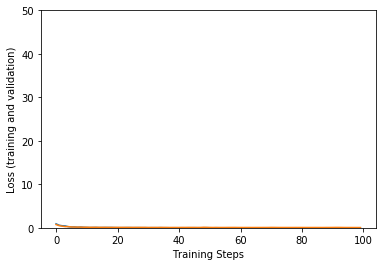

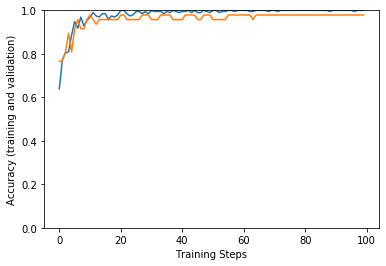

In [29]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [30]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [31]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Blank' 'Blurred Non Blank' 'Not Blank']


In [32]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 3)


In [33]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Blurred Non Blank' 'Blurred Non Blank' 'Blurred Non Blank'
 'Blurred Non Blank' 'Blurred Non Blank' 'Blurred Non Blank'
 'Blurred Non Blank' 'Blurred Non Blank' 'Not Blank' 'Not Blank'
 'Blurred Non Blank' 'Blurred Non Blank' 'Not Blank' 'Blurred Non Blank'
 'Blurred Non Blank' 'Blurred Non Blank' 'Blank' 'Blurred Non Blank'
 'Blurred Non Blank' 'Blurred Non Blank' 'Not Blank' 'Blurred Non Blank'
 'Not Blank' 'Blurred Non Blank' 'Blurred Non Blank' 'Blurred Non Blank'
 'Blurred Non Blank' 'Blurred Non Blank' 'Blurred Non Blank'
 'Blurred Non Blank' 'Not Blank' 'Blurred Non Blank']


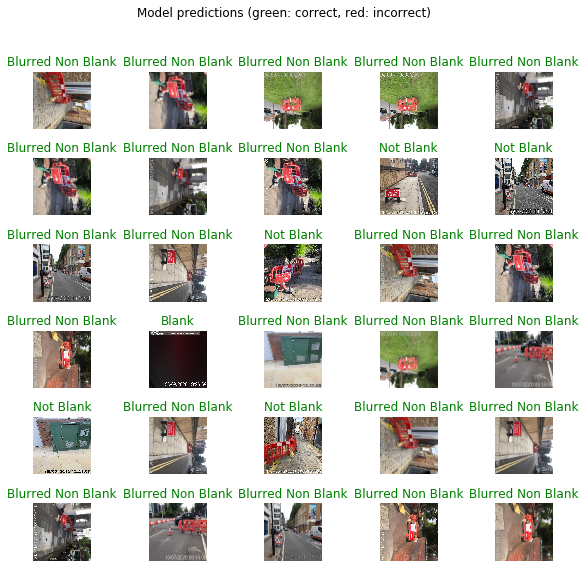

In [34]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [37]:
#model.predict(r"C:\Users\tanve\Desktop\telent\blank and non blank and blurred non blank\New folder\ss.jpg")

model.save('image_classify_model.h5')